In [67]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import slsim
from slsim.lens_pop import LensPop
import speclite
from astropy.cosmology import default_cosmology
from astropy.units import Quantity
from tqdm import tqdm
from hydra import initialize, compose

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.helpers import survey_sim

In [68]:
import mejiro
module_path = os.path.dirname(mejiro.__file__)
skypy_config = os.path.join(module_path, 'data', 'hwo.yml')
config_dict = util.load_skypy_config(skypy_config)
survey_area = float(config_dict['fsky'][:-5])

print(f"Survey area: {survey_area} deg^2")

Survey area: 0.01 deg^2


In [69]:
cosmo = default_cosmology.get()
sky_area = Quantity(value=survey_area, unit='deg2')

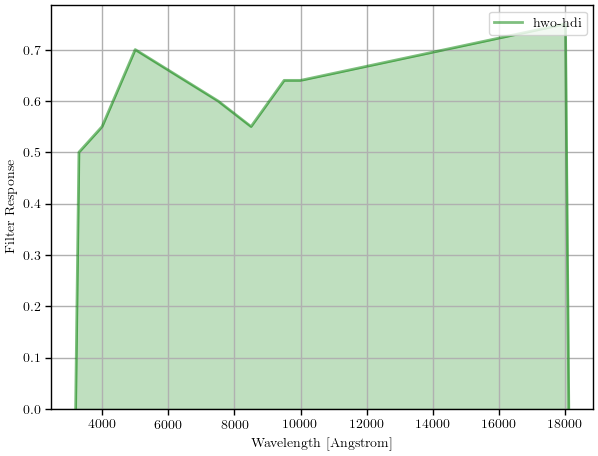

In [70]:
hwo_filter_path = os.path.join(repo_dir, 'mejiro', 'data', 'hwo-hdi.ecsv')
hdi = speclite.filters.load_filters(hwo_filter_path)

speclite.filters.plot_filters(hdi)

In [71]:
kwargs_deflector_cut = {"band": "hdi", "band_max": 28, "z_min": 0.01, "z_max": 5.0}
kwargs_source_cut = {"band": "hdi", "band_max": 30, "z_min": 0.01, "z_max": 8.0}

lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

In [72]:
kwargs_lens_cut = {
    "min_image_separation": 0.2,
    "max_image_separation": 10,
    "mag_arc_limit": {"hdi": 25},
}

lens_population = lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

print("Number of lenses:", len(lens_population))

Number of lenses: 386


In [73]:
from mejiro.instruments.hwo import HWO

hwo = HWO()
bands = hwo.get_bands()

for band in bands:
    print(f'{band}: {hwo.get_zeropoint_magnitude(band)}, noise: {hwo.get_noise(band)}')

FUV: 29.843166866741694, noise: 3.0005
NUV: 29.843148737948134, noise: 3.0005
U: 29.843139279326984, noise: 3.001
B: 29.843202335244925, noise: 3.001
V: 29.843158984694732, noise: 3.001
R: 29.843131397079745, noise: 3.001
I: 29.84322795066557, noise: 3.001
J: 29.84317474873143, noise: 4.002
H: 29.843257506169238, noise: 4.002
K: 29.843186571608754, noise: 4.002


In [74]:
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.Util import data_util
from lenstronomy.Util import util as len_util


def get_snr(gglens, band, mask_mult=1, zodi_mult=1.4):
    total_image, _, source_surface_brightness = get_image(gglens, band)

    # calculate region for source surface brightness array and count signal
    stdev = np.std(source_surface_brightness)
    mean = np.mean(source_surface_brightness)
    mask = source_surface_brightness < mean + (mask_mult * stdev)
    masked_source = np.ma.masked_array(source_surface_brightness, mask=mask)
    sum_source_counts = np.sum(masked_source)

    # estimate and add background
    hwo = HWO()
    estimated_background = hwo.get_noise('R')  # in counts/pixel
    # estimated_background *= np.ones(total_image.shape)
    bkg = np.random.poisson(estimated_background, total_image.shape)
    total_image += bkg

    # count total signal
    masked_total = np.ma.masked_array(total_image, mask=mask)
    sum_total_counts = np.sum(masked_total)

    # calculate estimated SNR
    return sum_source_counts / np.sqrt(sum_total_counts), total_image


def get_image(gglens, band):
    kwargs_model, kwargs_params = gglens.lenstronomy_kwargs(band=band)

    hwo = HWO()
    magnitude_zero_point = hwo.get_zeropoint_magnitude('R')
    lens_model = LensModel(kwargs_model['lens_model_list'])
    source_light_model = LightModel(kwargs_model['source_light_model_list'])
    lens_light_model = LightModel(kwargs_model['lens_light_model_list'])
    kwargs_lens = kwargs_params['kwargs_lens']
    kwargs_source = kwargs_params['kwargs_source']
    kwargs_lens_light = kwargs_params['kwargs_lens_light']
    kwargs_source_amp = data_util.magnitude2amplitude(source_light_model, kwargs_source, magnitude_zero_point)
    kwargs_lens_light_amp = data_util.magnitude2amplitude(lens_light_model, kwargs_lens_light, magnitude_zero_point)

    # set up image
    num_pix = 610  # at 8.2 mas/pixel, 5"  # 720
    psf_class = PSF(**{'psf_type': 'GAUSSIAN', 'fwhm': 0.0021})
    kwargs_numerics = {
        'supersampling_factor': 1,
        'supersampling_convolution': False
    }
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, Mcoord2pix = len_util.make_grid_with_coordtransform(
        numPix=num_pix,
        deltapix=0.0082,  # 0.00687549354156988
        subgrid_res=1,
        left_lower=False,
        inverse=False)
    kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0,
                    'transform_pix2angle': Mpix2coord}
    pixel_grid = PixelGrid(**kwargs_pixel)
    image_model = ImageModel(data_class=pixel_grid,
                             psf_class=psf_class,
                             lens_model_class=lens_model,
                             source_model_class=source_light_model,
                             lens_light_model_class=lens_light_model,
                             kwargs_numerics=kwargs_numerics)

    # get surface brightness arrays
    lens_surface_brightness = image_model.lens_surface_brightness(kwargs_lens_light_amp)
    source_surface_brightness = image_model.source_surface_brightness(kwargs_source_amp, kwargs_lens)
    total_image = image_model.image(kwargs_lens=kwargs_lens,
                                    kwargs_source=kwargs_source_amp,
                                    kwargs_lens_light=kwargs_lens_light_amp)

    return total_image, lens_surface_brightness, source_surface_brightness

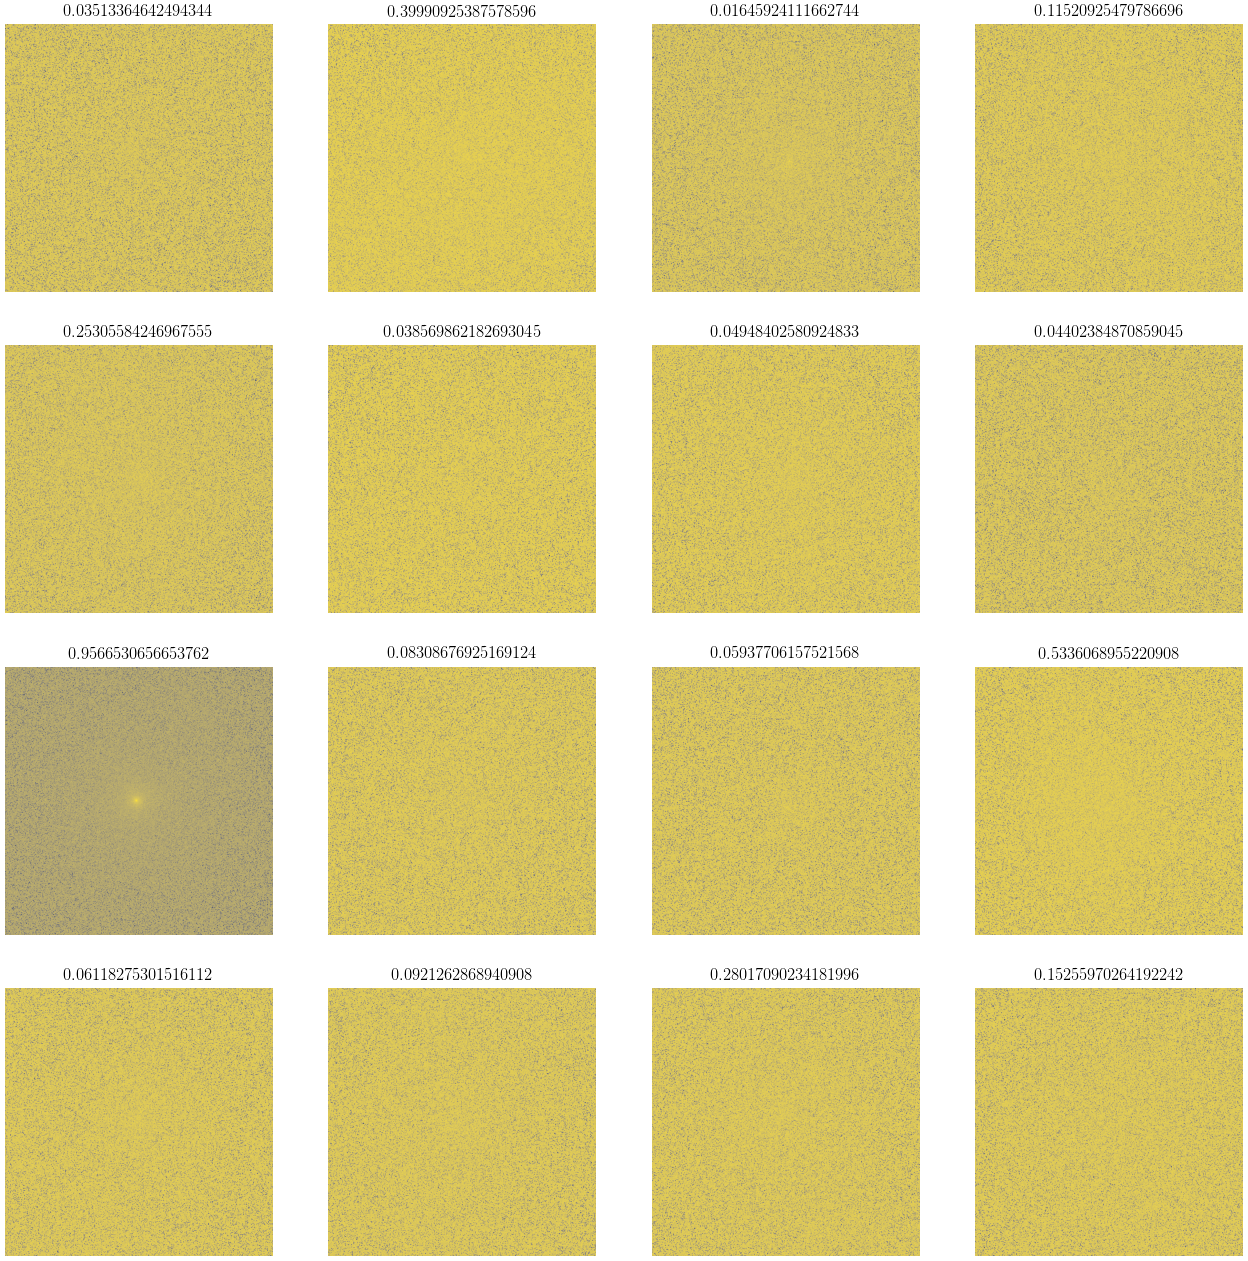

In [75]:
sample_lenses = np.random.choice(lens_population, 16)

snrs = [get_snr(lens, 'hdi') for lens in sample_lenses]

f, ax = plt.subplots(4, 4, figsize=(16, 16))
for i, (axi, snr) in enumerate(zip(ax.flatten(), snrs)):
    axi.imshow(np.log10(snr[1]), origin='lower', cmap='cividis')
    axi.set_title(snr[0])
    axi.axis('off')

plt.show()

In [76]:
output_dir = os.path.join(data_dir, 'hwo')
util.clear_directory(output_dir)

bands = ['hdi']

dict_list = []
for gglens in lens_population:

    # get lens params from gglens object
    kwargs_model, kwargs_params = gglens.lenstronomy_kwargs(band='hdi')

    # build dicts for lens and source magnitudes
    lens_mags, source_mags = {}, {}
    for band in bands:
        lens_mags[band] = gglens.deflector_magnitude(band)
        source_mags[band] = gglens.extended_source_magnitude(band)

    z_lens, z_source = gglens.deflector_redshift, gglens.source_redshift
    kwargs_lens = kwargs_params['kwargs_lens']

    # add additional necessary key/value pairs to kwargs_model
    kwargs_model['lens_redshift_list'] = [z_lens] * len(kwargs_lens)
    kwargs_model['source_redshift_list'] = [z_source]
    kwargs_model['cosmo'] = cosmo
    kwargs_model['z_source'] = z_source
    kwargs_model['z_source_convention'] = 8

    # create dict to pickle
    gglens_dict = {
        'kwargs_model': kwargs_model,
        'kwargs_params': kwargs_params,
        'lens_mags': lens_mags,
        'source_mags': source_mags,
        'deflector_stellar_mass': gglens.deflector_stellar_mass(),
        'deflector_velocity_dispersion': gglens.deflector_velocity_dispersion(),
        # 'snr': gglens.snr
    }

    dict_list.append(gglens_dict)

lens_dir = os.path.join(output_dir, 'lenses')
util.create_directory_if_not_exists(lens_dir)
util.clear_directory(lens_dir)
for i, each in tqdm(enumerate(dict_list), total=len(dict_list)):
    save_path = os.path.join(lens_dir, f'hwo_lens_{str(i).zfill(5)}.pkl')
    util.pickle(save_path, each)

pop_csv = os.path.join(output_dir, f'hwo_output.csv')
survey_sim.write_lens_pop_to_csv(pop_csv, lens_population, bands, suppress_output=False)

  0%|          | 0/386 [00:00<?, ?it/s]

100%|██████████| 386/386 [00:00<00:00, 933.73it/s]

Writing to /data/bwedig/mejiro/hwo/hwo_output.csv..


In [77]:
# detectable_gglenses, snr_list = [], []
# for candidate in tqdm(lens_population):
#     # 1. Einstein radius and Sersic radius
#     _, kwargs_params = candidate.lenstronomy_kwargs(band='hdi')
#     lens_mag = candidate.deflector_magnitude(band='hdi')

#     if kwargs_params['kwargs_lens'][0]['theta_E'] < kwargs_params['kwargs_lens_light'][0][
#         'R_sersic'] and lens_mag < 15:
#         continue

#     # 2. SNR
#     snr, _ = get_snr(candidate, 'hdi')
#     snr_list.append(snr)

#     if snr < 10:
#         continue

#     # if both criteria satisfied, consider detectable
#     detectable_gglenses.append(candidate)

# print(f'Number of lenses: {len(lens_population)}')
# print(f'Number of detectable lenses: {len(detectable_gglenses)}')
# print(f'Detectable lenses per square degree: {len(detectable_gglenses) / survey_area}')

In [78]:
# plt.hist(snr_list)
# plt.xlabel('SNR')
# plt.ylabel('Count')
# plt.yscale('log')
# plt.axvline(10, color='r', linestyle='--', label='SNR cutoff')
# plt.legend()
# plt.show()